# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)
dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [4]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 20

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'augmented_mlp_window_important_only10'
x_important = pd.read_csv('./data/features-important-names.csv').column_name.to_list()
x_important

x_cts   = [
    'net_charge_all_around_target_ser_thr',
    'HSE_alpha_down',
    'Tau(i-2=>i+2)'
]
x_cat   = [
    'SEQ', 'side_-1', 'side_1', 'side_2', 'side_3','side_4', 'side_5',
    'number_of_arg',
    'number_of_g',
    'number_of_ser',
    'number_of_thr',
    'number_of_v',
    'nAli',
    'nS/nT'
]
y_label = variables.y_label

print(f"{len(x_cts)} x_cts:")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

3 x_cts:
14 x_cat: ['SEQ', 'side_-1', 'side_1', 'side_2', 'side_3', 'side_4', 'side_5', 'number_of_arg', 'number_of_g', 'number_of_ser', 'number_of_thr', 'number_of_v', 'nAli', 'nS/nT']
1 y_label: ['positivity']
dummy x shape: (8910, 182)
dummy y shape: (8910, 1)


{0: 'net_charge_all_around_target_ser_thr',
 1: 'HSE_alpha_down',
 2: 'Tau(i-2=>i+2)',
 3: 'SEQ_S',
 4: 'SEQ_T',
 5: 'side_-1_cycle',
 6: 'side_-1_gly',
 7: 'side_-1_long',
 8: 'side_-1_normal',
 9: 'side_-1_pro',
 10: 'side_-1_small',
 11: 'side_-1_very_small',
 12: 'side_1_None',
 13: 'side_1_cycle',
 14: 'side_1_gly',
 15: 'side_1_long',
 16: 'side_1_normal',
 17: 'side_1_pro',
 18: 'side_1_small',
 19: 'side_1_very_small',
 20: 'side_2_None',
 21: 'side_2_cycle',
 22: 'side_2_gly',
 23: 'side_2_long',
 24: 'side_2_normal',
 25: 'side_2_pro',
 26: 'side_2_small',
 27: 'side_2_very_small',
 28: 'side_3_None',
 29: 'side_3_cycle',
 30: 'side_3_gly',
 31: 'side_3_long',
 32: 'side_3_normal',
 33: 'side_3_pro',
 34: 'side_3_small',
 35: 'side_3_very_small',
 36: 'side_4_None',
 37: 'side_4_cycle',
 38: 'side_4_gly',
 39: 'side_4_long',
 40: 'side_4_normal',
 41: 'side_4_pro',
 42: 'side_4_small',
 43: 'side_4_very_small',
 44: 'side_5_None',
 45: 'side_5_cycle',
 46: 'side_5_gly',
 47: 

## cross validation

In [6]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_data=[test_x, test_y], save_path=save_path, verbose=2)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
Epoch 1/10000
437/437 - 2s - loss: 0.5702 - accuracy: 0.7009 - val_loss: 0.5417 - val_accuracy: 0.7228 - 2s/epoch - 5ms/step
Epoch 2/10000
437/437 - 1s - loss: 0.5387 - accuracy: 0.7254 - val_loss: 0.5199 - val_accuracy: 0.7245 - 1s/epoch - 3ms/step
Epoch 3/10000
437/437 - 1s - loss: 0.5322 - accuracy: 0.7279 - val_loss: 0.5309 - val_accuracy: 0.7262 - 1s/epoch - 2ms/step
Epoch 4/10000
437/437 - 2s - loss: 0.5276 - accuracy: 0.7330 - val_loss: 0.5855 - val_accuracy: 0.6801 - 2s/epoch - 4ms/step
Epoch 5/10000
437/437 - 2s - loss: 0.5256 - accuracy: 0.7322 - val_loss: 0.5899 - val_accuracy: 0.6880 - 2s/epoch - 4ms/step
Epoch 6/10000
437/437 - 1s - loss: 0.5230 - accuracy: 0.7328 - val_loss: 0.5336 - val_accuracy: 0.7160 - 1s/epoch - 3ms/step
Epoch 7/10000
437/437 - 1s - loss: 0.522

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,29,1.229,0.511417,0.451215,0.451215,77.61,5.64,62.16,10.34
1,5,100,34,1.330,0.488040,0.441536,0.441536,78.68,4.99,51.35,9.09
2,5,100,13,0.888,0.486287,0.489320,0.489320,77.33,4.47,48.65,8.18
3,5,100,22,1.059,0.490602,0.467009,0.467009,77.10,4.20,45.95,7.69
4,5,100,11,0.850,0.491324,0.518288,0.518288,74.07,4.10,51.35,7.60
5,5,100,18,0.970,0.483584,0.475907,0.475907,76.43,3.41,37.84,6.25
6,5,100,1,0.704,0.506010,0.435335,0.435335,79.18,3.35,32.43,6.08
7,5,100,29,1.263,0.456051,0.409117,0.409117,81.99,2.67,21.62,4.75
8,5,100,25,1.214,0.508174,0.449564,0.449564,77.95,4.59,48.65,8.39
9,5,100,2,0.696,0.515010,0.471801,0.471801,75.70,5.00,59.46,9.22



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_1of20.h5


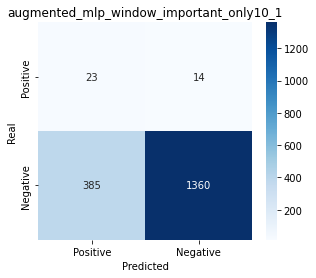

accuracy  : 77.61
precision : [98.98  5.64]
recall    : [77.94 62.16]
f1_score  : [87.21 10.34]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0160334676319485
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_2of20.h5


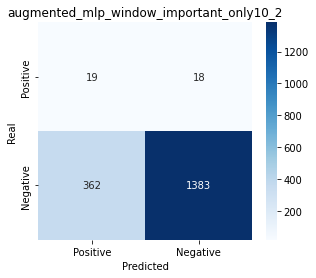

accuracy  : 78.68
precision : [98.72  4.99]
recall    : [79.26 51.35]
f1_score  : [87.92  9.09]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.00027793218454695475 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_3of20.h5


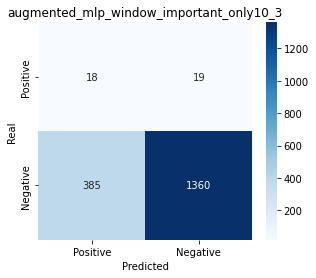

accuracy  : 77.33
precision : [98.62  4.47]
recall    : [77.94 48.65]
f1_score  : [87.07  8.18]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.03663003663003664 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_4of20.h5


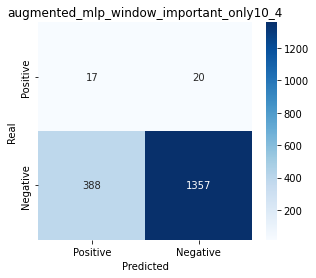

accuracy  : 77.10000000000001
precision : [98.55  4.2 ]
recall    : [77.77 45.95]
f1_score  : [86.93  7.69]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.044280442804428034 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_5of20.h5


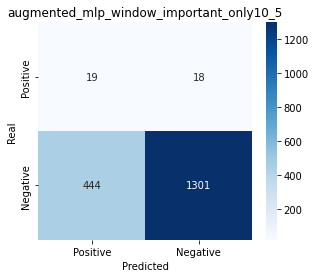

accuracy  : 74.07000000000001
precision : [98.64  4.1 ]
recall    : [74.56 51.35]
f1_score  : [84.92  7.6 ]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_6of20.h5


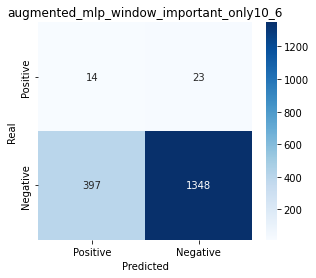

accuracy  : 76.42999999999999
precision : [98.32  3.41]
recall    : [77.25 37.84]
f1_score  : [86.52  6.25]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_7of20.h5


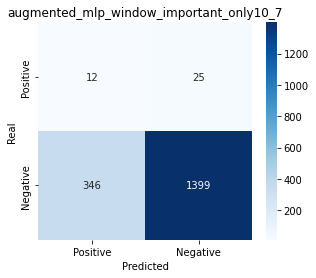

accuracy  : 79.17999999999999
precision : [98.24  3.35]
recall    : [80.17 32.43]
f1_score  : [88.29  6.08]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.070510462046319 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_8of20.h5


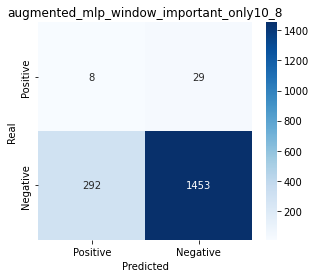

accuracy  : 81.99
precision : [98.04  2.67]
recall    : [83.27 21.62]
f1_score  : [90.05  4.75]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.03663003663003664 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_9of20.h5


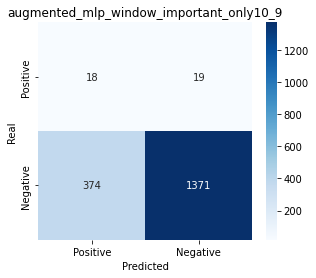

accuracy  : 77.95
precision : [98.63  4.59]
recall    : [78.57 48.65]
f1_score  : [87.46  8.39]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0179856115107915
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_10of20.h5


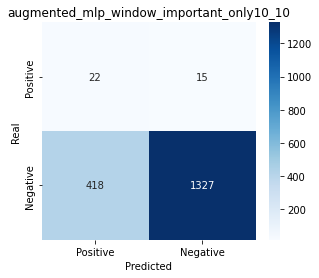

accuracy  : 75.7
precision : [98.88  5.  ]
recall    : [76.05 59.46]
f1_score  : [85.97  9.22]

11th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_11of20.h5


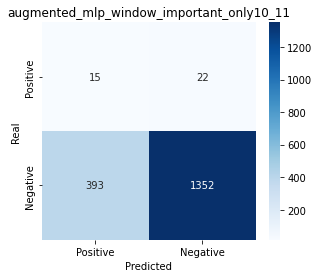

accuracy  : 76.71
precision : [98.4   3.68]
recall    : [77.48 40.54]
f1_score  : [86.69  6.74]

12th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_12of20.h5


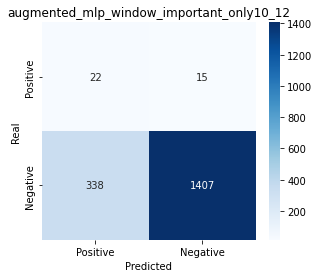

accuracy  : 80.19
precision : [98.95  6.11]
recall    : [80.63 59.46]
f1_score  : [88.85 11.08]

13th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.010714285714286
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_13of20.h5


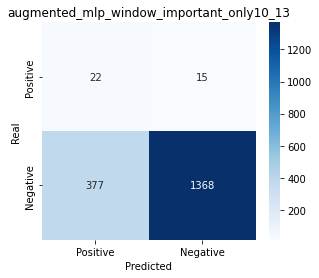

accuracy  : 78.0
precision : [98.92  5.51]
recall    : [78.4  59.46]
f1_score  : [87.47 10.09]

14th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_14of20.h5


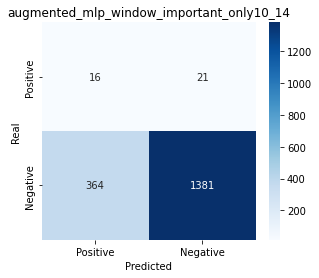

accuracy  : 78.4
precision : [98.5   4.21]
recall    : [79.14 43.24]
f1_score  : [87.77  7.67]

15th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.07172207301241748 1.0171834211680892
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_15of20.h5


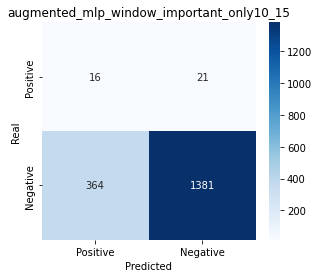

accuracy  : 78.4
precision : [98.5   4.21]
recall    : [79.14 43.24]
f1_score  : [87.77  7.67]

16th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_16of20.h5


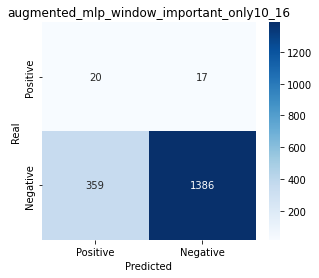

accuracy  : 78.9
precision : [98.79  5.28]
recall    : [79.43 54.05]
f1_score  : [88.06  9.62]

17th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.03663003663003664 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_17of20.h5


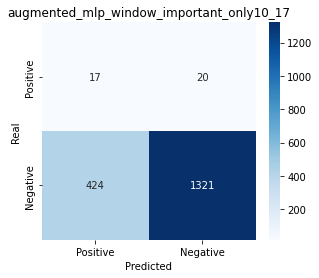

accuracy  : 75.08
precision : [98.51  3.85]
recall    : [75.7  45.95]
f1_score  : [85.61  7.11]

18th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.044280442804428034 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_18of20.h5


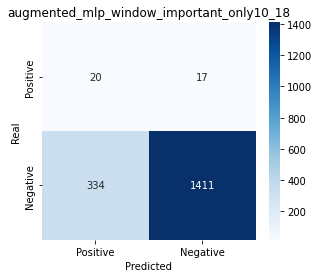

accuracy  : 80.30000000000001
precision : [98.81  5.65]
recall    : [80.86 54.05]
f1_score  : [88.94 10.23]

19th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: -0.044280442804428034 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_19of20.h5


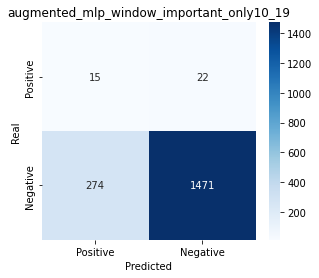

accuracy  : 83.39
precision : [98.53  5.19]
recall    : [84.3  40.54]
f1_score  : [90.86  9.2 ]

20th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 182) (7128, 1)
check scale: 0.0 1.0

test: (1782, 182) (1782, 1)
check scale: 0.0 1.0
up-sampled train dataset: (13960, 182) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_important_only10_5_100_cv_20of20.h5


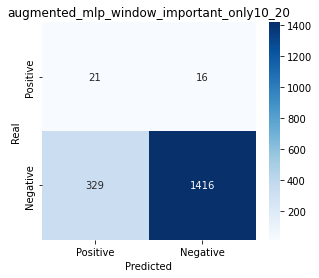

accuracy  : 80.64
precision : [98.88  6.  ]
recall    : [81.15 56.76]
f1_score  : [89.14 10.85]


In [7]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])